# Protein Simulation at the Oil/Water Interface


In [1]:
# importing libraries
import numpy as np
from matplotlib import pyplot as plt
import random
from scipy      import optimize
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd
import scipy.stats as stats
from tkinter import filedialog
from tkinter.filedialog import asksaveasfilename

After imporing the libraries that we need, we define the number of droplets and the size of field of view

In [2]:
NumDrop = 100
x_fov = 20000
y_fov = 20000

The droplets radius sizes are filled in the radius array randomly in a certain range

In [3]:
radius = [0 for i in range(NumDrop)]
for i in range(NumDrop):
    radius[i] = abs(np.random.normal(loc = 750  , scale =200))

We define two function in order to calculate the center of all droplets and fit the radius. the center calculation and radius is used to prevent droplet overlapping

In [4]:
#Fitting to find the center in order to avoid cross section between droplets
def calc_R(xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x_mo[counter]-xc)**2 + (y_mo[counter]-yc)**2)

def f_2(c):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(*c)
    return Ri - Ri.mean()

First we define the position of the molecules around the droplets based on the gaussian distribution, and check whether the droplets overlapping or not

In [5]:
m_density = 0.1 #molecule density at the oil interface/// play With it for heterogeneous distribution 
lower, upper = 0, 2*np.pi #Range for the distribution
x_mo = [0 for i in range(NumDrop)] 
y_mo = [0 for i in range(NumDrop)]
x_center = [0 for i in range(NumDrop)]
y_center = [0 for i in range(NumDrop)]
R_fit = [0 for i in range(NumDrop)]
Mol = [0 for i in range(NumDrop)]
Nr = [0 for i in range(NumDrop)]
centerf = np.zeros((NumDrop,2))
flag = 'false'
counter = 0
while flag == 'false':
    Nr[counter] = int(m_density*2*np.pi*radius[counter])
    #Molecules deviation for the distribution
    sigma = radius[counter]/20
    #define the mean and variance for truncated normal distribution
    mu_m, sigma_m = random.random()*2*np.pi, np.pi   ####Sigma_m  =  Heterogeneous (random.random() * (2.5 - 0.8) + 0.8) and Homogeneous np.pi
    #Return gaussian spaced nterval distribution for the molecules on the droplets
    Mol[counter] = stats.truncnorm(
        (lower - mu_m) / sigma_m, (upper - mu_m) / sigma_m, loc=mu_m, scale=sigma_m)
    theta = Mol[counter].rvs(Nr[counter])
    #calculating the molecule positions
    x_mo[counter] = radius[counter] * np.cos(theta) + np.random.randn(int(Nr[counter]))*sigma + random.randrange(0,x_fov)
    y_mo[counter] = radius[counter] * np.sin(theta) + np.random.randn(int(Nr[counter]))*sigma + random.randrange(0,y_fov)
    #We use the functions to check the overlap    
    xm = np.mean(x_mo[counter], axis = 0)
    ym = np.mean(y_mo[counter], axis = 0)
    center_estimate = xm, ym
    center, ier = optimize.leastsq(f_2, center_estimate)
    centerf[counter]= center.reshape(1,2)
    x_center[counter] , y_center[counter] = centerf[counter] 
    Ri_fit = calc_R(x_center[counter],y_center[counter])
    R_fit[counter] = np.mean(Ri_fit)
    if counter > 0:
        m = 1
        j = counter
        while m == 1:
            R_cr = np.sqrt((centerf[counter,0] - centerf[j - 1,0] )**2 + (centerf[counter,1] - centerf[j - 1,1])**2)
            if R_cr < R_fit[counter] + R_fit[j - 1]:
                counter = counter - 1
                m = 0;
            j = j - 1
            if j == 0:
                m = 0;          
    counter = counter + 1
    if counter == NumDrop:
        flag = 'True'

We calculate the fluorophore positions around each molecule for all droplets

In [6]:
#Fluorophore density for each molecule that is calculated in the last part
F_density = 0.2
#Radius of fluorophore distibution around a molecule
radius_m = 3
x_wr = [0 for i in range(NumDrop)]
y_wr = [0 for i in range(NumDrop)]
Fl = [0 for i in range(NumDrop)]
for i in range(NumDrop):
    x = [0 for i in range(Nr[i])]
    y = [0 for i in range(Nr[i])]
    Nr_fl = F_density*2*np.pi*radius_m
    mu_f, sigma_f = random.random()*2*np.pi, np.pi  
    #Return gaussian spaced nterval distribution for the fluorophores
    Fl[i] = stats.truncnorm(
        (lower - mu_f) / sigma_f, (upper - mu_f) / sigma_f, loc=mu_f, scale=sigma_f)
    sigma_fl = radius_m/0.2
    theta_fl = Fl[i].rvs(int(Nr_fl))
    xhe = np.hstack(x_mo[i])
    yhe = np.hstack(y_mo[i])
    #calculating the position of the fluorophores based on the position of each molecule around a droplet
    for kk in range(int(Nr[i])):
        x[kk] = radius_m * np.cos(theta_fl) + np.random.randn(int(Nr_fl))*sigma_fl + xhe[kk]
        y[kk] = radius_m * np.sin(theta_fl) + np.random.randn(int(Nr_fl))*sigma_fl + yhe[kk]
    x_wr[i] = np.hstack(x)
    y_wr[i] = np.hstack(y)
    

Plot the droplets

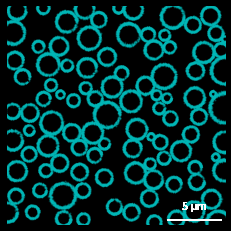

In [7]:
plt.style.use('dark_background')
for i in range(NumDrop):
    plt.scatter(x_wr[i], y_wr[i] , s = 1, alpha = 0.1, color = 'c')
    ax=plt.gca()
    plt.xlim(0,x_fov)
    plt.ylim(0,y_fov)
    ax.set_aspect('equal')
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    plt.axis('off')
    scalebar = ScaleBar(1, "nm", length_fraction=0.3, location = 'lower right', scale_loc = 'top',color = 'w', box_alpha = '0')
    ax.patch.set(alpha = 0.1)
    ax.add_artist(scalebar)
plt.show() 
a = asksaveasfilename(filetypes=(("PNG Image", "*.png"),("All Files", "*.*")), defaultextension='.png', title="Window-2")
if a:
    plt.savefig(a)